# Microscopic Analysis: Individual-Level Diagnosis

While we had already analysed on our model using metrics such as Recall and F1-Score, these metrics only provide us with a broad overview of the model performance, and often miss out important details on why our model fails in certain instances. Thus, we analysed our model based on individual misclassified instances, allowing us to further understand the weaknesses of our model.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE
from mpl_toolkits.mplot3d import Axes3D

## Importing Model
We first import the final model from `tuning.ipynb`.


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325

🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.219196
1                                            age    0.205463
2                             log_years_employed    0.136391
3                                    family_size    0.055888
4                                        own_car    0.028670
5                                          phone    0.023868
6                                         gender    0.022395
7                                     own_realty    0.021279
8                            income_type_Working    0.020557
9                                     work_phone    0.018295
10                             occupation_Others    0.016678
11  education_type_Secondary / secondary special    0.016418
12                         family_status_Married    0.015781
13               education_type_Higher edu

C:\Users\ashle\AppData\Local\Temp\ipykernel_19608\2754918906.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


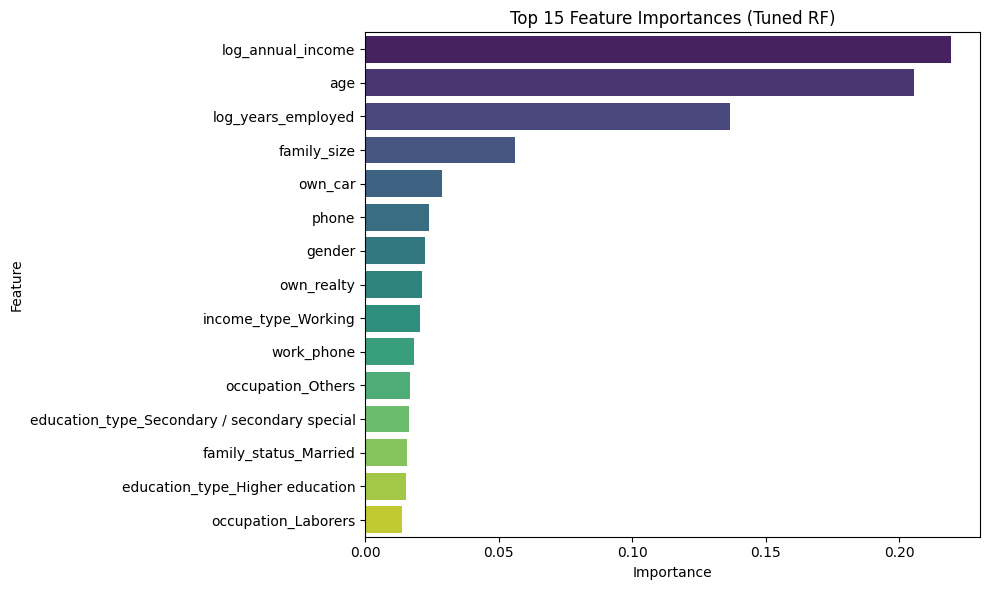

In [6]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\nNo threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Identifying Misclassified Instances

We first separated misclassified instances (`misclassified_df`) and correctly classified test samples (`classified_df`). To make the comparision more manageable, we randomly sampled 1000 data points from each group.

In [ ]:
# Get predicted and actual labels
y_pred = y_pred_custom
y_true = y_test_binary

# Identify indices of misclassified instances
misclassified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] != y_true.iloc[i]:
        misclassified_ind.append(X_test_reduced.index[i])

# Create a DataFrame for the misclassified instances
misclassified_df = X_test_reduced.loc[misclassified_ind].copy()
misclassified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in misclassified_ind]]
misclassified_df['Actual'] = y_test.loc[misclassified_ind].values

# Identify indices of correctly classified instances
classified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] == y_true.iloc[i]:
        classified_ind.append(X_test_reduced.index[i])

# Create a DataFrame for the correctly classified instances
classified_df = X_test_reduced.loc[classified_ind].copy()
classified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in classified_ind]]
classified_df['Actual'] = y_test.loc[classified_ind].values
#print(classified_df.head(10))

# Randomly sample 1000 data points from each group
sample_correct = classified_df.sample(1000, random_state=42)
sample_incorrect = misclassified_df.sample(1000, random_state=42)

## Comparing Feature Distributions

To simplify our analysis, we focused on the top 3 most important features identified in the earlier feature importance graph: `log_annual_income`, `age`, and `log_years_employed`. We then compared the distributions of these features between correctly and incorrectly classified instances.

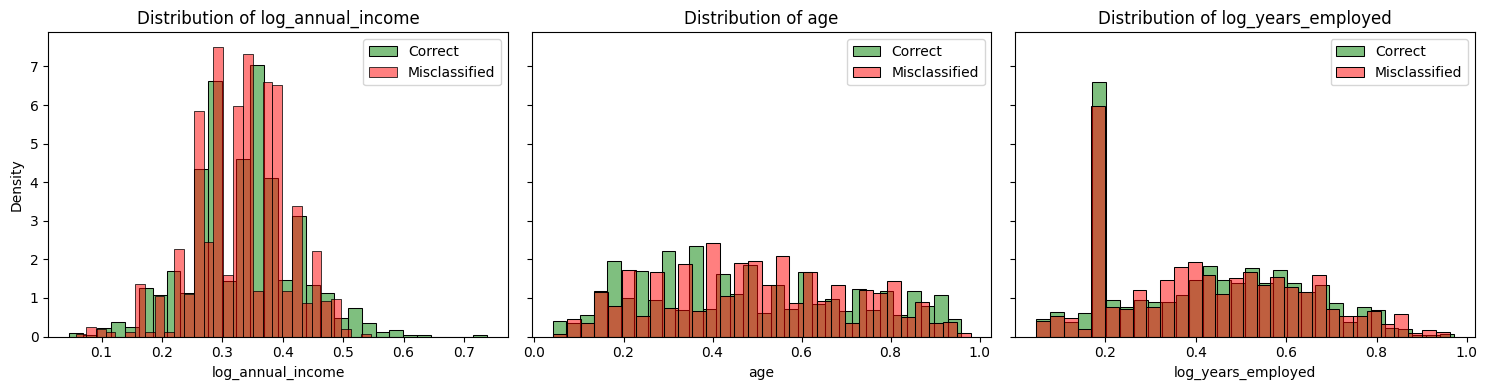

In [10]:
# Distributions of top individual features among correct vs. misclassified predictions
features = ['log_annual_income', 'age', 'log_years_employed']
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, col in enumerate(features):
    sns.histplot(sample_correct[col], bins=30, color='green', label='Correct', ax=axes[i], stat='density', alpha=0.5)
    sns.histplot(sample_incorrect[col], bins=30, color='red', label='Misclassified', ax=axes[i], stat='density', alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()


The distribution of `log_annual_income` for misclassified instances were slightly more concentrated in the middle, suggesting that the model is more likely to misclassify individuals with the moderate income levels. `age` and `log_years_employed` do not show strong differences between the 2 groups, so these features may have limited influence on misclassification.

## Clustering Misclassifications

To better understand the nature of our model's errors, we  plotted combinations of the top 3 features to investigate whether misclassified instances formed clusters in the feature space.

By examining pairwise combinations, we explored whether misclassifications were influenced by pairwise interactions between the top 3 features.

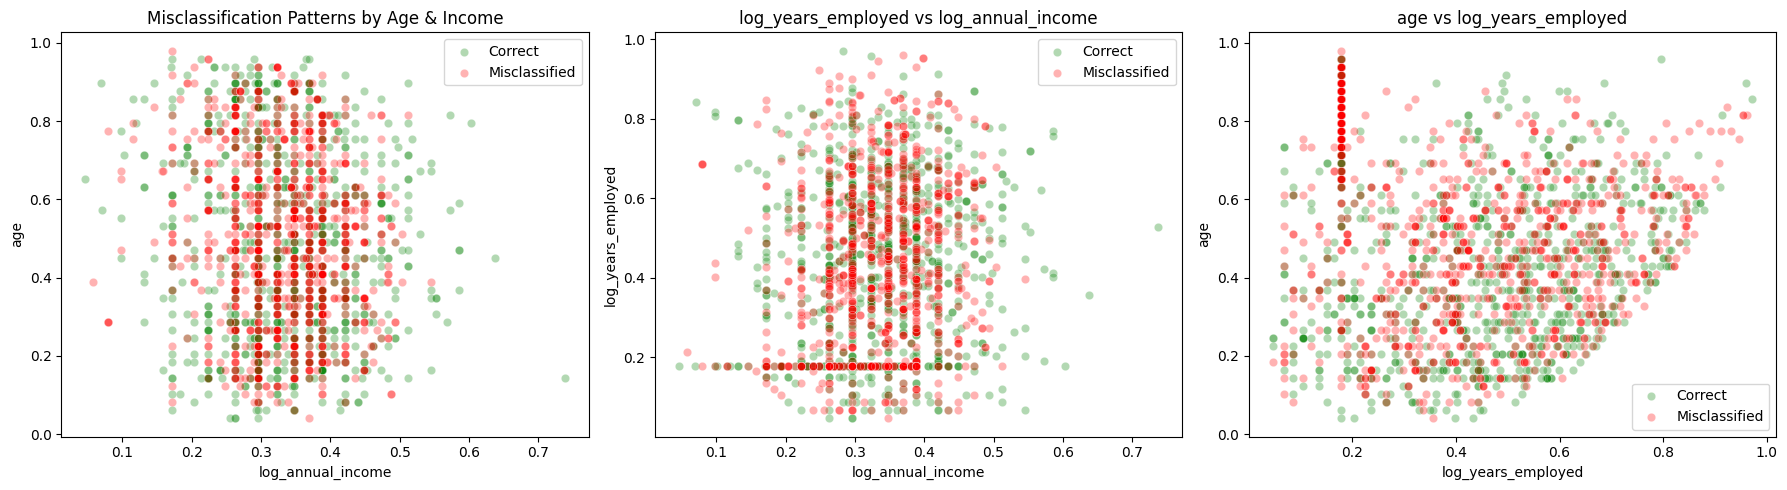

In [ ]:
# Define the feature pairs and titles
feature_pairs = [
    ('log_annual_income', 'age', "Misclassification Patterns by Age & Income"),
    ('log_annual_income', 'log_years_employed', "log_years_employed vs log_annual_income"),
    ('log_years_employed', 'age', "age vs log_years_employed")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each combination
for ax, (x_feat, y_feat, title) in zip(axes, feature_pairs):
    sns.scatterplot(data=sample_correct, x=x_feat, y=y_feat, color='green', label='Correct', alpha=0.3, ax=ax)
    sns.scatterplot(data=sample_incorrect, x=x_feat, y=y_feat, color='red', label='Misclassified', alpha=0.3, ax=ax)
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

We also generated an interactive 3D scatterplot to further examine inter-feature relationships. This plot is has been exported as a HTML file `interactive_3d_plot_misclassified.html`, please open the file in your web browser to interact with it.

In [ ]:
# Combine correct and misclassified samples
correct_points = sample_correct.copy()
correct_points["classification"] = "Correct"

misclassified_points = sample_incorrect.copy()
misclassified_points["classification"] = "Misclassified"

combined_df = pd.concat([correct_points, misclassified_points])

# Interactive 3D scatterplot (exported to HTML)
fig = px.scatter_3d(
    combined_df,
    x="log_annual_income",
    y="age",
    z="log_years_employed",
    color="classification",
    opacity=0.5,
    title="Interactive 3D Scatter Plot of Feature Interactions",
    height=600
)
fig.update_layout(legend_title_text='Prediction Outcome')
fig.write_html("interactive_3d_plot_misclassified.html")

# sorry phoon ann can u add ur analysis here

## Analysis on False Negatives

To further our analysis, we focused on false negatives (wrongly approving a risky applicant), following the same line of justification from the macroanalysis. We repeat the steps above for the false negatives.

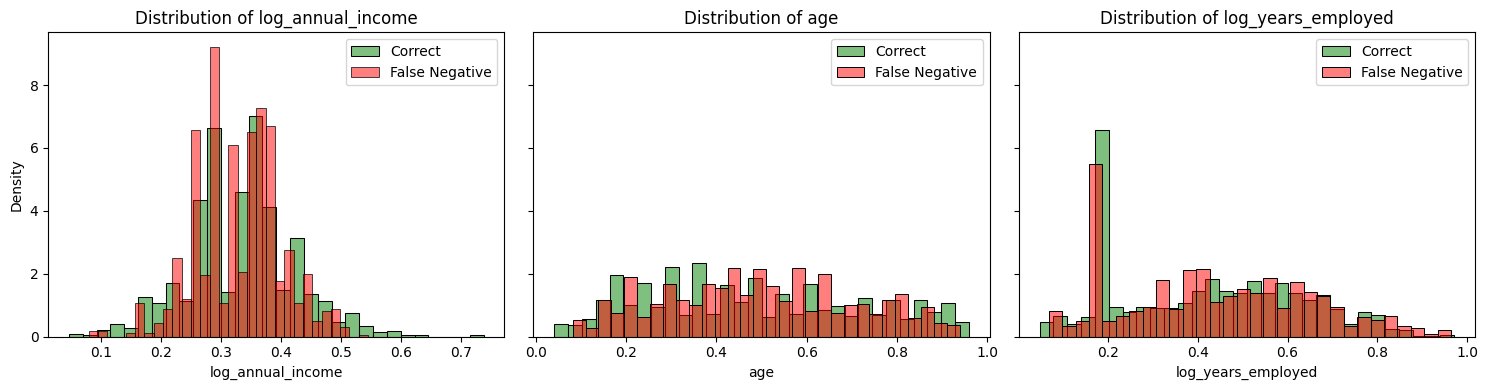

In [40]:
# Extract False Negatives
fn_points = misclassified_df[misclassified_df['Actual'] == 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, col in enumerate(features):
    sns.histplot(sample_correct[col], bins=30, color='green', label='Correct', ax=axes[i], stat='density', alpha=0.5)
    sns.histplot(fn_points[col], bins=30, color='red', label='False Negative', ax=axes[i], stat='density', alpha=0.5)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

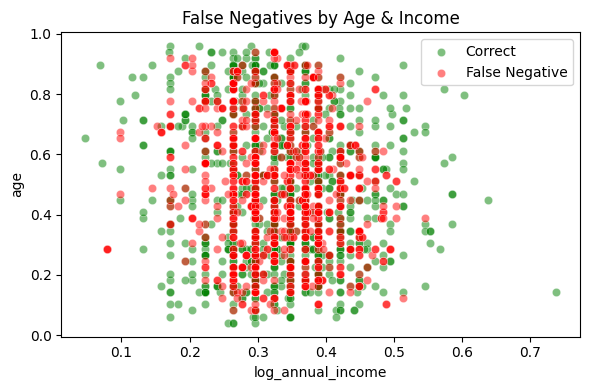

In [35]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_correct, x='log_annual_income', y='age', color='green', label='Correct', alpha=0.5)
sns.scatterplot(data=fn_points, x='log_annual_income', y='age', color='red', label='False Negative', alpha=0.5)
plt.title("False Negatives by Age & Income")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Combine FN points and correctly classified points
subset_fn_points_labeled = fn_points.copy()
subset_fn_points_labeled["classification"] = "False Negative"

subset_correct_labeled = sample_correct.copy()
subset_correct_labeled["classification"] = "Correct"
subset_combined = pd.concat([subset_fn_points_labeled, subset_correct_labeled])

# Interactive 3D scatterplot (exported to HTML)
fig = px.scatter_3d(
    subset_combined,
    x="log_annual_income",
    y="age",
    z="log_years_employed",
    color="classification",
    opacity=0.6,
    title="3D Scatter Plot of False Negatives vs Correct (Dense Region)",
    height=600
)
fig.write_html("interactive_3d_plot_fns.html")

# sorry phoon ann can u add ur analysis here, jus say the results are similar to the total misclassifications -- more or less clustered arnd median log_annual_income

## Analysing the Dense Region

We then narrowed our analysis to a dense region where `log_annual_income` falls between 0.28 and 0.30, and examined 10 representative points from both the false negative group and the correctly classified group.

In [45]:
# Filter samples with log_annual_income between 0.28 and 0.30
subset_fn_points = fn_points[(fn_points['log_annual_income'] >= 0.28) & (fn_points['log_annual_income'] <= 0.30)]
subset_correct = sample_correct[(sample_correct['log_annual_income'] >= 0.28) & (sample_correct['log_annual_income'] <= 0.30)]

# Display a sample of each group for side-by-side comparison
print("False Negatives in Dense Region:")
print(subset_fn_points.head(10))

False Negatives in Dense Region:
     gender  own_car  own_realty  work_phone  phone  email  family_size  \
53        0        0           1           0      0      0          1.0   
101       1        1           1           0      0      0          2.0   
114       1        1           1           0      1      0          2.0   
154       1        1           1           0      0      0          2.0   
177       0        1           1           0      0      1          2.0   
303       0        0           1           0      1      0          1.0   
364       0        1           1           0      0      0          3.0   
368       1        0           1           1      1      0          2.0   
561       0        0           1           0      1      0          2.0   
587       1        0           1           0      1      0          2.0   

          age  log_annual_income  log_years_employed  ...  \
53   0.469388           0.283389            0.343027  ...   
101  0.591837      

In [46]:
print("\nCorrectly Classified in Same Region:")
print(subset_correct.head(10))


Correctly Classified in Same Region:
      gender  own_car  own_realty  work_phone  phone  email  family_size  \
4958       0        0           1           0      1      0          2.0   
7201       0        0           0           1      0      0          2.0   
5903       1        0           0           0      0      0          2.0   
5510       1        1           0           1      0      1          2.0   
2883       0        0           0           0      0      0          2.0   
5324       0        0           1           0      0      0          2.0   
2040       0        0           1           0      0      0          2.0   
1868       0        0           1           0      1      0          3.0   
932        0        0           1           0      0      0          2.0   
1979       0        0           1           1      1      0          1.0   

           age  log_annual_income  log_years_employed  ...  \
4958  0.918367           0.283389            0.496303  ...   
7

# sorry phoon ann can u add ur analysis here, just say not much diff tbh. 

in conclusion, <add what u said in the slides, but rephrase a bit >